Investigate no background trained analysis

Check performance Cluster-3 and Cluster-4

06-28 data (4000 by 4000) is a sort of limit to analyze on the jupyter (otherwise consider multiprocessing)

In [1]:
import os
import sys
import glob
import numpy as np
import tensorflow as tf
import matplotlib 
import matplotlib.pyplot as plt
from matplotlib import patches as mpl_patches

In [11]:
from sklearn.metrics import silhouette_score as sil

In [2]:
sys.path.insert(1, os.path.join(sys.path[0],"/home/tkurihana/scratch-midway2/data/MOD06/" ) )
from analysis_lib import _get_swath,_gen_patches, _load_tif_data
from analysis_lib import cv2_interpolation
from analysis_lib import _cluster_plotting
from analysis_lib import cluster_plotting2
from analysis_lib import _get_colors

In [3]:
sys.path.insert(1, os.path.join(sys.path[0],"/home/tkurihana/scratch-midway2/data/MOD06/" ) )
from mod_sdslib import _get_hdf4, _retrive_data

### Tif data

In [5]:
tifdir='/home/tkurihana/scratch-midway2/data/GEE/clouds_gee_2015_2016'
tifname='2015-06-01_MOD09GA_background_removal_zero_inputated_image_with_cf_10perc_grid_size10-0000000000-0000000000.tif'

In [6]:
swath1 = _get_swath(tifdir, tifname)

 Shape  (17664, 17664, 7)


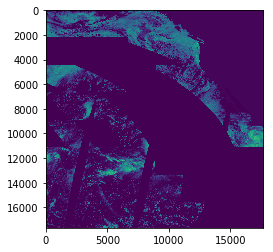

In [9]:
plt.imshow(swath1[:,:,0])

### Data in analysis

In [7]:
datadir = '/home/tkurihana/scratch-midway2/anl'

In [8]:
SHAPE = 128, 128, 7

In [14]:
patches = _gen_patches(swath1, normalization=True)

ValueError: all input arrays must have the same shape

#### labeled data

In [ ]:
n_cluster = 3
colors = _get_colors(n=n_cluster)

In [11]:
knn_label = np.load(datadir+'/knn_label_spark_1.0-nc3-key2015-06-01-ID0.npy')

In [12]:
knn_label.shape

(9172,)

#### Reconstruct label array to 2D

In [13]:
def gen_label_index(patches, knn_label):
    patches_labels = np.zeros((patches.shape[:2]))
    idx = 0
    for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
            if np.all( patches[i,j] <= 1.0e-5 ):
                patches_labels[i,j] = np.nan
            else:
                patches_labels[i,j] = knn_label[idx]
                idx += 1
    return patches_labels

In [14]:
patches_labels = gen_label_index(patches, knn_label)

In [15]:
patches_labels.shape

(138, 138)

In [16]:
patches.shape

(138, 138, 128, 128, 7)

In [24]:
patches_labels

array([[ 1.,  0.,  2., ..., nan, nan, nan],
       [ 2.,  2.,  2., ..., nan, nan, nan],
       [ 0.,  0.,  0., ..., nan, nan, nan],
       ...,
       [ 0.,  2.,  2., ..., nan, nan, nan],
       [ 2.,  2.,  1., ..., nan, nan, nan],
       [ 0.,  0.,  0., ..., nan, nan, nan]])

In [ ]:
plt.imshow(patches_labels)

#### Plotting 

In [18]:
 def nobk_cluster_plotting(swath, patches,patches_labels,
                      SHAPE, colors, ncluster=0):
    line_width = 4
    fig, a = plt.subplots(figsize=(20,20))
    plt.imshow(swath[:,:,0], cmap="bone")
    rects = []
    for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
            if not np.isnan(patches_labels[i,j]) :
                a.add_patch(mpl_patches.Rectangle(
                  (j * SHAPE[0] + line_width , i * SHAPE[1] + line_width ),
                  width=SHAPE[0] - line_width * 2,
                  height=SHAPE[1] - line_width * 2,
                  linewidth=1,
                  edgecolor=colors[int(patches_labels[i,j])],
                  facecolor="none"
                  ))
                centerx = SHAPE[0]*0.5*(2*j+1) #+1
                centery = SHAPE[1]*0.5*(2*i+1) #+1
                # add label as text
                plt.text(centerx, centery, str(patches_labels[i,j]),
                   fontsize=1,weight='bold',
                   color=colors[int(patches_labels[i,j])])
    plt.title(" ## %d cluster ## " %ncluster, fontsize=20)


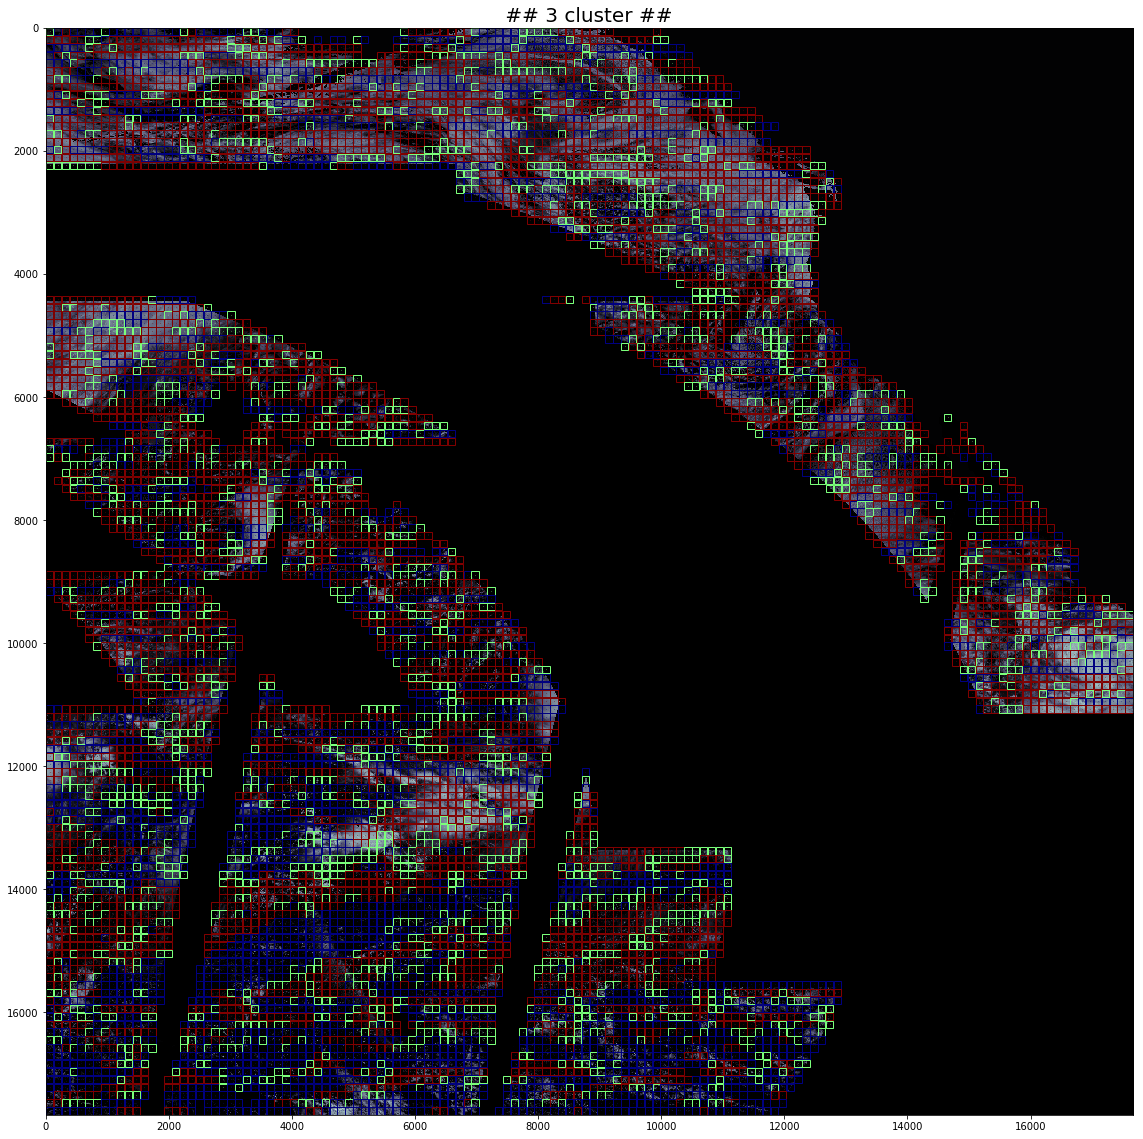

In [19]:
nobk_cluster_plotting(swath1, patches, patches_labels, SHAPE, colors, ncluster=n_cluster)

### Comparing to cloud top height 

In [20]:
hdf_datadir = '/project2/chard/clouds/data/MOD06/2015-06-01-cth'

In [21]:
hdffilelist = glob.glob(hdf_datadir+"/*.hdf")

In [23]:
hdffilelist.sort()

In [24]:
hdffilelist

['/project2/chard/clouds/data/MOD06/2015-06-01-cth/MOD06_L2.A2015152.mosaic.061.2019078020044.psmcgscs_000501315390.Cloud_Top_Height.hdf',
 '/project2/chard/clouds/data/MOD06/2015-06-01-cth/MOD06_L2.A2015152.mosaic.061.2019078020117.psmcgscs_000501315395.Cloud_Top_Height.hdf',
 '/project2/chard/clouds/data/MOD06/2015-06-01-cth/MOD06_L2.A2015152.mosaic.061.2019078020401.psmcgscs_000501315397.Cloud_Top_Height.hdf',
 '/project2/chard/clouds/data/MOD06/2015-06-01-cth/MOD06_L2.A2015152.mosaic.061.2019078020512.psmcgscs_000501315396.Cloud_Top_Height.hdf',
 '/project2/chard/clouds/data/MOD06/2015-06-01-cth/MOD06_L2.A2015152.mosaic.061.2019078020519.psmcgscs_000501315391.Cloud_Top_Height.hdf',
 '/project2/chard/clouds/data/MOD06/2015-06-01-cth/MOD06_L2.A2015152.mosaic.061.2019078020520.psmcgscs_000501315394.Cloud_Top_Height.hdf',
 '/project2/chard/clouds/data/MOD06/2015-06-01-cth/MOD06_L2.A2015152.mosaic.061.2019078020529.psmcgscs_000501315400.Cloud_Top_Height.hdf',
 '/project2/chard/clouds/da

In [25]:
hdffile = hdffilelist[0]
varname = 'Cloud_Top_Height'
iname = os.path.basename(i)[:-4]
cth_hdf = _get_hdf4(hdf_datadir, iname)
cth_sds = cth_hdf.select(varname)
cth = _retrive_data(cth_sds)

NameError: name 'i' is not defined

### Sil Score for Different N_clusters in No-Background case

In [4]:
# encoder part
model_dir='/home/tkurihana/clouds/output/m9-22_oceans/'
ENCODER_DEF=model_dir+'encoder.json'
ENCODER_WEIGHTS=model_dir+'encoder.h5'
with open(ENCODER_DEF,"r") as f:
    encoder = tf.keras.models.model_from_json(f.read())
encoder.load_weights(ENCODER_WEIGHTS)

/home/tkurihana/.conda/envs/tf-cpu/lib/python3.6/site-packages/tensorflow/python/keras/layers/core.py:791: UserWarning: models is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


In [10]:
encs = encoder.predict( patches.reshape((-1,128,128,7)) )
encs_mean = encs.mean(axis=(1,2))

### N = 3

In [12]:
n_cluster = 3

In [ ]:
knn_label = np.load()